## Code for vizualisation of Chebyshev Linear Regression task

In [151]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt

from function_classes import ChebyshevKernelLinearRegression
from parse import get_x_distribution
from utils import FakeLinspaceDistribution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
NUM_EXAMPLES = int(1e6)
SEQ_LEN = 31 #31
#x_distribution = torch.distributions.Uniform(-torch.ones((NUM_EXAMPLES, SEQ_LEN, 1)), torch.ones((NUM_EXAMPLES, SEQ_LEN, 1)))
chebyshev_linear_comb_class = ChebyshevKernelLinearRegression(lowest_degree=0, highest_degree=11, #x_distribution=x_distribution)
                                                              x_distribution=get_x_distribution(batch_size=NUM_EXAMPLES,
                                                                                                seq_len=SEQ_LEN,
                                                                                                x_dim=1,
                                                                                                init_kwargs={'type' : 'uniform'}))

x_values, y_values = next(chebyshev_linear_comb_class)

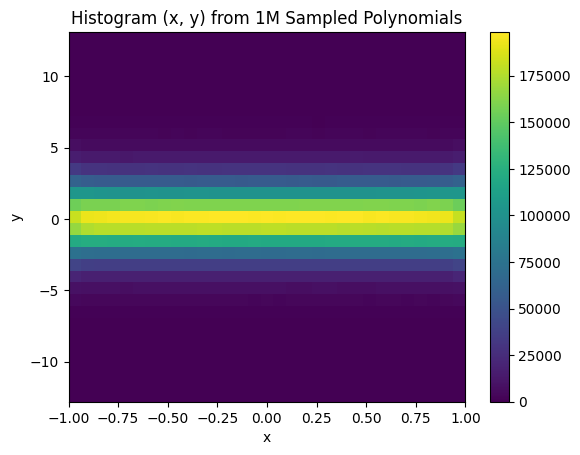

In [158]:
def plot_distribution(x_values: torch.Tensor, y_values: torch.Tensor):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    _, _, _, img = ax.hist2d(x_values.reshape(-1), y_values.reshape(-1), bins=[31,31])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Histogram (x, y) from 1M Sampled Polynomials")
    plt.xlim([-1, 1])
    plt.colorbar(img)
    plt.show()

plot_distribution(x_values, y_values)

In [154]:
NUM_POLYS = 5
SEQ_LEN = 1000
#x_distribution = torch.distributions.Uniform(-torch.ones((NUM_EXAMPLES, SEQ_LEN, 1)), torch.ones((NUM_EXAMPLES, SEQ_LEN, 1)))
chebyshev_linear_comb_class = ChebyshevKernelLinearRegression(lowest_degree=0, highest_degree=11, #x_distribution=x_distribution)
                                                              x_distribution=FakeLinspaceDistribution(batch_shape=(NUM_POLYS, SEQ_LEN, 1)))

x_values, y_values = next(chebyshev_linear_comb_class)

Sample shape torch.Size([5, 1000, 1])


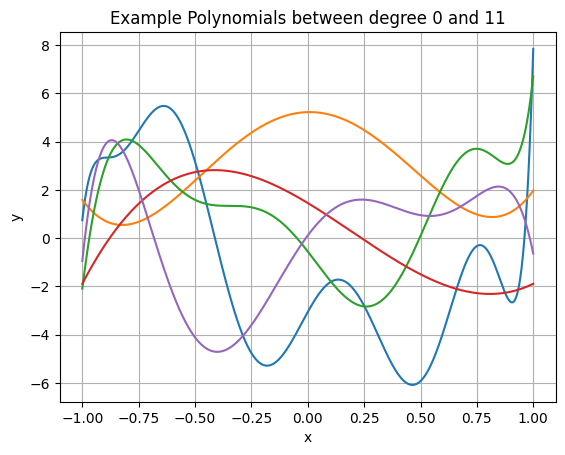

In [155]:
for x, y in zip(x_values, y_values):
    plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Example Polynomials between degree 0 and 11")
plt.grid()
plt.show()